In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import PReLU
from keras.initializers import Constant

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=16, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
image_size = 128
train_path = r"D:\pggan keras\stage1_train"
epochs = 35
batch_size = 16

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 30

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [5]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


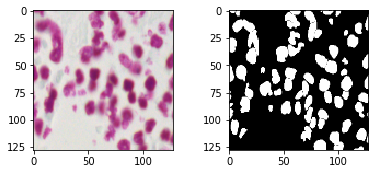

In [6]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=PReLU(alpha_initializer=Constant(value=0)))(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=PReLU(alpha_initializer=Constant(value=0)))(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=PReLU(alpha_initializer=Constant(value=0)))(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=PReLU(alpha_initializer=Constant(value=0)))(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=PReLU(alpha_initializer=Constant(value=0)))(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=PReLU(alpha_initializer=Constant(value=0)))(c)
    return c

In [8]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
   
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [9]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
________________________________________________________________________________

In [10]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history_relu = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/35
39/39 [==============================] - 91s 2s/step - loss: 0.4756 - acc: 0.8142 - val_loss: 0.3975 - val_acc: 0.8176
Epoch 2/35
39/39 [==============================] - 66s 2s/step - loss: 0.3170 - acc: 0.8449 - val_loss: 0.2737 - val_acc: 0.8173
Epoch 3/35
39/39 [==============================] - 66s 2s/step - loss: 0.2256 - acc: 0.8518 - val_loss: 0.1975 - val_acc: 0.8972
Epoch 4/35
39/39 [==============================] - 66s 2s/step - loss: 0.1704 - acc: 0.9187 - val_loss: 0.1385 - val_acc: 0.9237
Epoch 5/35
39/39 [==============================] - 66s 2s/step - loss: 0.1322 - acc: 0.9332 - val_loss: 0.1192 - val_acc: 0.9357
Epoch 6/35
39/39 [==============================] - 66s 2s/step - loss: 0.1105 - acc: 0.9422 - val_loss: 0.0959 - val_acc: 0.9417
Epoch 7/35
39/39 [==============================] - 65s 2s/step - loss: 0.1050 - acc: 0.9432 - val_loss: 0.1016 - val_acc: 0.9384
Epoch 8/35
39/39 [==============================] - 66s 2s/step - loss: 0.1050 - acc: 0.94

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


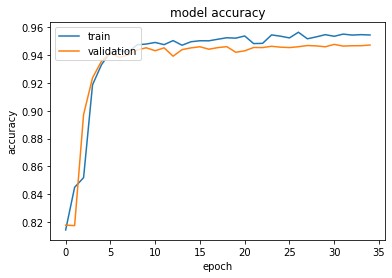

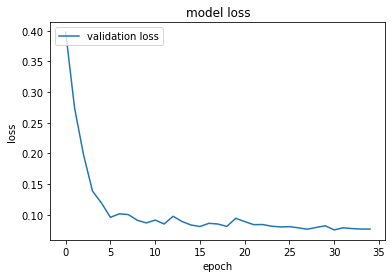

In [11]:
print(history_relu.history.keys())
#  "Accuracy"
plt.plot(history_relu.history['acc'])
plt.plot(history_relu.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
#plt.plot(history_relu.history['loss'])
plt.plot(history_relu.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation loss', 'validation'], loc='upper left')
plt.show()

In [12]:
## Save the Weights
model.save_weights("UNetW.hprelu")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

0.7498482088646024
0.8570437196391395
0.25015179113539765


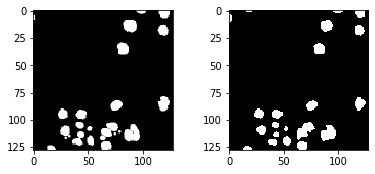

In [13]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

y_pred=np.reshape(result[0]*255, (image_size, image_size))
y_true=np.reshape(y[0]*255, (image_size, image_size))
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
mean, std_1 = cv2.meanStdDev(y_pred, y_true)
print(iou_score) 
img1 = np.asarray(y_true).astype(np.bool)
img2 = np.asarray(y_pred).astype(np.bool)
if img1.sum() + img2.sum() == 0:
    print(1) 
intersection = np.logical_and(img1, img2)
print(2. * intersection.sum() / (img1.sum() + img2.sum()))
intersection=abs(intersection)
union=abs(union)
voe=1-(intersection.sum()/union.sum())
print(voe)

0.8181184668989547
0.8999616711383672
0.18188153310104527


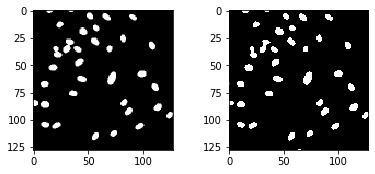

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)

ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")
y_pred=np.reshape(result[1]*255, (image_size, image_size))
y_true=np.reshape(y[1]*255, (image_size, image_size))
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
mean, std_1 = cv2.meanStdDev(y_pred, y_true)
print(iou_score) 
img1 = np.asarray(y_true).astype(np.bool)
img2 = np.asarray(y_pred).astype(np.bool)
if img1.sum() + img2.sum() == 0:
    print(1) 
intersection = np.logical_and(img1, img2)
print(2. * intersection.sum() / (img1.sum() + img2.sum()))
intersection=abs(intersection)
union=abs(union)
voe=1-(intersection.sum()/union.sum())
print(voe)